#Bidirectional Long Short Therm Memory
##Word Embedding: GloVe 840B 300d
##Optimizers: Adam
**Word Embeddings**

Words and ngrams have been primarily used as features in text classification. I did vectorized the texts using bag of words based features, now I will rely on neural embedding models. I will use a pre-trained embedding model. There are several pre-trained word2vec models trained on large corpora that one can download from the internet. GloVe(Global Vector) is one of popular pre-trained embedding algorithm from Stanford.

The advantage of using embedding based features is that they create a dense, low-dimensional feature representation instead of the sparse, high-dimensional structure of bag of words/TFIDF and other such features.

**GloVe Embeddings**

GloVe is commonly used method of obtaining pre-trained embeddings. GloVe aims to achieve two goals:

Create word vectors that capture meaning in vector space Takes advantage of global count statistics instead of only local information There are a lot of online material available to explain the concept about GloVe. So my focus here will be on, how to use pre-trained Glove word embeddings. I will provide relevant resources to look into more details.

**Download the pre-trained glove file:** I will be using glove.6B file which is trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2020-10-08 19:12:26--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-10-08 19:12:26--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-10-08 19:12:27--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
!unzip -q ./glove.840B.300d.zip

In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers, initializers, optimizers, constraints
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import SpatialDropout1D
from keras.layers import concatenate,  Bidirectional
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.engine.topology import Layer

import sys


from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve


In [ ]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.1   # data for validation (not used in training)
EMBEDDING_DIM = 300      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "/content/glove.840B."+str(EMBEDDING_DIM)+"d.txt"

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

**Preprocessing**

In [ ]:
def cleanData(text):
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text

special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def text_to_wordlist(text):
    text = text.lower().split()


    text = " ".join(text)

    #Remove Special Characters
    text=special_character_removal.sub('',text)
    #Replace Numbers
    text=replace_numbers.sub('',text)

    return(text)

In [ ]:
print('Processing text dataset')

train['comment_text'] = train['comment_text'].map(lambda x: cleanData(x))
test['comment_text'] = test['comment_text'].map(lambda x: cleanData(x))
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Processing text dataset
Train shape:  (159571, 8)
Test shape:  (153164, 2)


In [ ]:
list_sentences_train = train["comment_text"].fillna("NA").values
y_train = train[labels].values
list_sentences_test = test["comment_text"].fillna("NA").values

comments = []
for text in list_sentences_train:
    comments.append(text_to_wordlist(text))

test_comments=[]
for text in list_sentences_test:
    test_comments.append(text_to_wordlist(text))

In [ ]:
train.comment_text[0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

**Evaluation Metric**

To evaluate the model, I'll be looking at its AUC ROC score (area under the receiver operating characteristic curve). I will be looking at the probability that the model ranks a randomly chosen positive instance higher than a randomly chosen negative one. With data that mostly consists of negative labels (no toxicity), our model could just learn to always predict negative and end up with a pretty high accuracy. AUC ROC helps correct this by putting more weight on the the positive examples.


In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [ ]:
def plot_graphs(history, metric, optimizer):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.title(optimizer)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

**Tokenizing**

When dealing with text, it is typical to assign a unique integer id to each word in the corpus. This makes it simpler to represent the data as we feed it into a model.

Because this is such a common operation, Keras has built-in support for it. We need to fit the tokenizer object on our corpus so that it can assign a unique id to each word. We also initialize the tokenizer with a num_words parameter so that it knows how many of the top frequency words to take into account.

**Padding**

Our model would expect each input row to be of the same dimension. This means once we decide on what the chosen input comment size is, we need to chop off some part of the input comments that are too long. We would also, need to pad the comments which are shorter.

Keras has built in support for this using the pad_sequences method.

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS) # define Tokenize text function
tokenizer.fit_on_texts(comments)#fit the function on the text
sequences = tokenizer.texts_to_sequences(comments)# convert  to sequence
test_sequences = tokenizer.texts_to_sequences(test_comments)
word_index = tokenizer.word_index #num of unique tokens
print('Vocabulary size:', len(word_index))

Vocabulary size: 169740


In [ ]:
#Limit size  to 200 and pad the sequence
data = pad_sequences(sequences, padding = 'post',truncating='post', maxlen = MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(test_sequences, padding = 'post',truncating='post', maxlen = MAX_SEQUENCE_LENGTH)

In [ ]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')

for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...")
print(f'Found {len(embeddings_index)} word vectors', end="")

nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/glove.840B.300d.txt ...Done.
 Proceeding with Embedding Matrix...
Found 2196016 word vectors Completed!


In [ ]:
del(train)
del(test)

**Model definition**


This is  multi-label classification problem. This means, for each input instance, multiple output classes could be possible at the same time. A comment could be both "toxic" and "obscene" at the same time.

Few things to keep in mind:

We can arrange for the output size of our final fully-connected layer to be same as the number of output classes we are trying to predict.
We should use the "sigmoid" activation instead of "softmax" activation we use in a classification problem. This is because in case of sigmoid, the value for each class is independent of the others, while this is not the case for softmax.
We should use "binary-crossentropy" as the loss instead of "categorical_crossentropy" we typically use in a classification problem.

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

x = Embedding(nb_words,
              EMBEDDING_DIM,
              weights = [embedding_matrix],
              input_length = MAX_SEQUENCE_LENGTH,
              trainable=True)
embedded_sequences = x(sequence_input)
x = Bidirectional(LSTM(200,return_sequences=True))(embedded_sequences)
x = GlobalMaxPool1D()(x)

x = Dense(75, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

model = Model(inputs=[sequence_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 400)          801600    
_________________________________________________________________
global_max_pooling1d (Global (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 75)                30075     
_________________________________________________________________
dropout (Dropout)            (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                

In [ ]:
X_tra, X_val, y_tra, y_val = train_test_split(data, y_train, train_size=0.8, random_state=233)

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val]

In [ ]:
hist_adam = model.fit(X_tra, y_tra, batch_size=400, epochs=20, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)
print('Predicting....')
y_pred_Adam_pre = model.predict(data_test,batch_size=1024,verbose=1)

Epoch 1/20
320/320 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.7871
 ROC-AUC - epoch: 1 - score: 0.972991
320/320 [==============================] - 21s 66ms/step - loss: 0.1031 - accuracy: 0.7871 - val_loss: 0.0511 - val_accuracy: 0.9938
Epoch 2/20
319/320 [============================>.] - ETA: 0s - loss: 0.0529 - accuracy: 0.9445
 ROC-AUC - epoch: 2 - score: 0.977311
320/320 [==============================] - 20s 64ms/step - loss: 0.0529 - accuracy: 0.9445 - val_loss: 0.0490 - val_accuracy: 0.9938
Epoch 3/20
320/320 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9613
 ROC-AUC - epoch: 3 - score: 0.980194
320/320 [==============================] - 20s 63ms/step - loss: 0.0489 - accuracy: 0.9613 - val_loss: 0.0457 - val_accuracy: 0.9938
Epoch 4/20
319/320 [============================>.] - ETA: 0s - loss: 0.0465 - accuracy: 0.9605
 ROC-AUC - epoch: 4 - score: 0.981666
320/320 [==============================] - 20s 64ms/step - loss: 

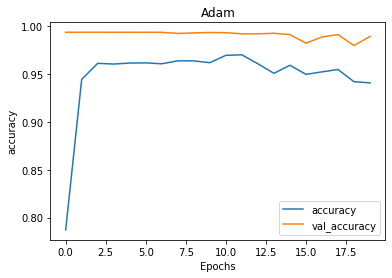

In [ ]:
plot_graphs(hist_adam, 'accuracy','Adam')

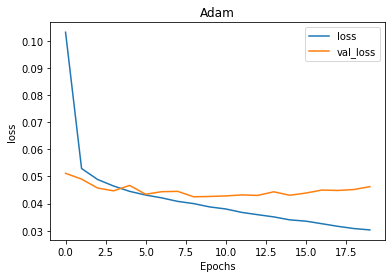

In [ ]:
plot_graphs(hist_adam, 'loss','Adam')

In [ ]:
submission = pd.read_csv('/content/submission_gru.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred_Adam_pre
submission.to_csv('lstm_glove840_Adam_yesprocess.csv', index=False)